In [121]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import os
import mlflow
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import nn

In [143]:
# load model and labels
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')
path = '/home/riikoro/fossil_data/tooth_samples/v1'
label_filename = 'labels.txt'
with open(os.path.join(path, label_filename)) as label_file:
    labels = label_file.read().splitlines()

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
def evaluate(generated, label):
    """
    Generate word counts required for precision and recall

    Args:
        generated: sentence generated with OCR
        label:     correct text in the image

    Returns:
        int: count of correct words in the generated sequence (correct word in wrong position is wrong)
        int: count of words in the generated sequence
        int: count of words in the label
    """
    generated_words = generated.split(' ')
    label_words = label.split(' ')
    correct_words = 0

    generated_word_count = len(generated_words)
    label_word_count = len(label_words)
    for i in range(generated_word_count):
        if i >= label_word_count:
            break
        if label_words[i] == generated_words[i]:
            correct_words += 1

    return correct_words, generated_word_count, label_word_count

In [102]:
total_correct = 0
total_generated = 0
total_label_words = 0

# empty arrays to store model outputs
predicted_labels = [''] * len(labels)

for file in os.listdir(path):
    if not file.endswith('.png'):
        continue
    img_path = os.path.join(path, file)
    img_no = int(file.split('.')[0])

    with Image.open(img_path) as image:
        pixel_values = processor(images=image, return_tensors="pt").pixel_values

        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predicted_labels[img_no] = generated_text
        
        correct_label = labels[img_no]
        print(f'--- reading dental marking from {file} ---')
        print(generated_text)
        print(correct_label)
        print
        correct_word_count, generated_word_count, label_word_count = evaluate(generated_text, correct_label)
        print(correct_word_count)
        print(generated_word_count)
        print(label_word_count)

        total_correct += correct_word_count
        total_generated += generated_word_count
        total_label_words += label_word_count

/home/riikoro/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


--- reading dental marking from 9.png ---
Left mandible frog with broken Px, M, and
Left mandible frag with broken P4̌, M1̌ and

4
8
8
--- reading dental marking from 35.png ---
A- Proximal # distal end right femur
Proximal & distal end right femur

0
7
6
--- reading dental marking from 10.png ---
Isolated.
Isolated

0
1
1
--- reading dental marking from 44.png ---
As Lktibia.
A= Lt tibia

0
2
3
--- reading dental marking from 34.png ---
proximal.
proximal

0
1
1
--- reading dental marking from 58.png ---
As left mandibular corpus with teeth " : " 3
A= Left mandibular corpus with teeth M1̄̌-M3̄̌

4
10
7
--- reading dental marking from 13.png ---
Shalt lacking desstal A proximal ends
Shaft lacking distal & proximal ends

2
6
6
--- reading dental marking from 56.png ---
isolated # RC. RM3, HM3, WHO, HM2.
Isolated L.C̱, RM3̱̂, LM3̱̂, LM2̱̂, LM3̌

0
7
6
--- reading dental marking from 19.png ---
10kote.
lokote

0
1
1
--- reading dental marking from 21.png ---
llms.
M3̂

0
1
1
--- reading d

In [103]:
precision = total_correct / total_generated
recall = total_correct / total_label_words
f1 = (2*precision*recall)/(precision+recall)


In [104]:
print(precision)
print(recall)
print(f1)

0.3310344827586207
0.3490909090909091
0.3398230088495576


### OCR performance with difflib SequenceMatcher

In [108]:
print(labels)
print(predicted_labels)

['Distal half left humerus with broken medial\n', 'Isolated\n', 'LI2̌, RM̱2̌ & tooth frags (8)\n', 'LM2̌\n', 'right maxilla with frag of zygomatic and\n', 'Isolated\n', 'anterior\n', 'man\n', 'Isolated RC̱, RP4̱̂, RM\n', 'Left mandible frag with broken P4̌, M1̌ and\n', 'Isolated\n', 'M3̂\n', 'frag wi I2̄̌ alveolus, croots P3̄̌-M2̄̌\n', 'Shaft lacking distal & proximal ends\n', 'Frag left mandibular corpus lacking teeth\n', 'proximal frag. right ulna\n', 'L mandible frag with roots M2̌-̌3̌\n', 'A: 4 upper premolar (P3̱̌) unerrupted. L. mbs\n', 'frag. right ulna proximal erd. wt. shaft.\n', 'lokote\n', 'A = frag left mandible corpus with M3̌ roots\n', 'M3̂\n', 'RT.mandible frag with P4̌-M2̌\n', 'Mandible lacking left ascending ramus;\n', 'Rt P4̄̌\n', 'LM1̂\n', 'Broken molar !(M̱)\n', 'Isolated RM2̌, RM3̌, broken LM3̌\n', 'L mandible frag with M1̌-̌3̌\n', 'Proximal part right femur\n', 'A= R mandible with M2̄̌-̌3̄̌ M1̌ root\n', 'Left ulna lacking distal epiphysis\n', 'A = distal end left 

In [138]:
from difflib import SequenceMatcher
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

def sequence_matcher_score(labels, predicted_labels):
    similarities = np.array([0.0] * len(labels))
    for i in range(len(labels)):
        similarities[i] = similarity(predicted_labels[i], labels[i])
    return np.mean(similarities)

sequence_score = sequence_matcher_score(labels, predicted_labels)
print(f"Sequence matcher score, baseline: {sequence_score}")

Sequence matcher score, baseline: 0.7303534415690215


### MLflow logging

In [139]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db
mlflow.set_experiment("Dental element OCR")

params = {
    'data_v': 1
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("sequence matcher score", sequence_score)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Untuned TrOCR-handwritten-large")


env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


## Train on V1 data & check how metrics change

todo:
- uniformize train image sizes
- perform training (try allowing any weight change & only last layer changes)
- log metrics to mlflow

In [70]:
# modified from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
class DentalElementDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        with open(os.path.join(img_dir, annotations_file)) as label_file:
            labels = label_file.readlines()
        self.img_labels = pd.Series(labels)
        self.img_dir = img_dir
        self.transform = transforms.Resize((200,2000)) # data transformation applied to training data
        self.target_transform = transforms.Resize((200,3000)) # data transformation applied to test data

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{idx}.png")
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        sample=self.transform(image)

        return sample, label

In [71]:
dental_data = DentalElementDataset(label_filename, path)
train_loader = torch.utils.data.DataLoader(dental_data, batch_size=4, shuffle=True)

### Sanity check: print image & corresponding label

L mandible frag with M1̌-̌3̌


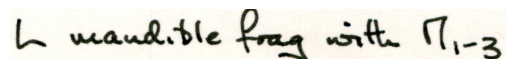

In [72]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images[0])
# matplotlib_imshow(img_grid, one_channel=True)

npimg = img_grid.numpy()
print(labels[0])
plt.axis('off')
plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Create character to unicode code point a & unicode code point to character functions

Cross-entropy loss needs predictions and ground truths to be tensors -> convert characters to 1d tensors of code points

In [153]:
test_labels = labels[:10]
test_label = labels[2]
print(test_label)

unicode_ids = [ord(char) for char in test_label]
print(unicode_ids)
and_back = [chr(uid) for uid in unicode_ids]
print(''.join(and_back))

LI2̌, RM̱2̌ & tooth frags (8)
[76, 73, 50, 780, 44, 32, 82, 77, 817, 50, 780, 32, 38, 32, 116, 111, 111, 116, 104, 32, 102, 114, 97, 103, 115, 32, 40, 56, 41]
LI2̌, RM̱2̌ & tooth frags (8)


In [165]:
# output: 2d tensor, each row is one sequence -> 2d tensor is batch labels
def strings_to_code_point_tensor(sequences):
    # but: what if labels are of different lengths?? add 0's to the back? this would not be necessary with ctc loss
    final_tensor = None
    for sequence in sequences:
        unicode_tensor = torch.tensor([ord(char) for char in sequence])

# input: 2d tensor, each row is one sequence -> 2d tensor is batch labels
def code_point_tensors_to_string(point_tensors):
    return ''.join([chr(uid) for uid in point_tensor])

print(string_to_code_point_tensor(test_label))
print(code_point_tensor_to_string(string_to_code_point_tensor(test_label)))
print(list(map(string_to_code_point_tensor, test_labels)))

tensor([ 76,  73,  50, 780,  44,  32,  82,  77, 817,  50, 780,  32,  38,  32,
        116, 111, 111, 116, 104,  32, 102, 114,  97, 103, 115,  32,  40,  56,
         41])
LI2̌, RM̱2̌ & tooth frags (8)
[tensor([ 68, 105, 115, 116,  97, 108,  32, 104,  97, 108, 102,  32, 108, 101,
        102, 116,  32, 104, 117, 109, 101, 114, 117, 115,  32, 119, 105, 116,
        104,  32,  98, 114, 111, 107, 101, 110,  32, 109, 101, 100, 105,  97,
        108]), tensor([ 73, 115, 111, 108,  97, 116, 101, 100]), tensor([ 76,  73,  50, 780,  44,  32,  82,  77, 817,  50, 780,  32,  38,  32,
        116, 111, 111, 116, 104,  32, 102, 114,  97, 103, 115,  32,  40,  56,
         41]), tensor([ 76,  77,  50, 780]), tensor([114, 105, 103, 104, 116,  32, 109,  97, 120, 105, 108, 108,  97,  32,
        119, 105, 116, 104,  32, 102, 114,  97, 103,  32, 111, 102,  32, 122,
        121, 103, 111, 109,  97, 116, 105,  99,  32,  97, 110, 100]), tensor([ 73, 115, 111, 108,  97, 116, 101, 100]), tensor([ 97, 110, 116, 

### Define hyperparameters

current: from pytorch tutorial https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [73]:
print(type(model)) # vision encoder decoder model
print(isinstance(model, nn.Module)) # is a torch neural network
print(type(processor)) # trocrprocessor, what is this?
print(isinstance(processor, nn.Module)) # not a neural network
print(type(processor).__mro__)

<class 'transformers.models.vision_encoder_decoder.modeling_vision_encoder_decoder.VisionEncoderDecoderModel'>
True
<class 'transformers.models.trocr.processing_trocr.TrOCRProcessor'>
False
(<class 'transformers.models.trocr.processing_trocr.TrOCRProcessor'>, <class 'transformers.processing_utils.ProcessorMixin'>, <class 'transformers.utils.hub.PushToHubMixin'>, <class 'object'>)


In [85]:
learning_rate = 1e-3
batch_size = 4
epochs = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [158]:
# from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# next: pred and y should be tensors not strings. option: convert to unicode ids. better: see trocr repo for their implementation.
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pixels = processor(images=X, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixels)
        pred = processor.batch_decode(generated_ids, skip_special_tokens=True)
        print(pred)
        print(y)
        loss = loss_fn(string_to_code_point_tensor(pred), string_to_code_point_tensor(y))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss = loss.item()
        print(f"loss: {loss:>7f}")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pixels = processor(images=X, return_tensors="pt").pixel_values
            pred = model.generate(pixels)
            test_loss += loss_fn(string_to_code_point_tensor(pred), string_to_code_point_tensor(y)).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item() use f1 instead of this

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [159]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(train_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/home/riikoro/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/riikoro/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generat

['Isolated RC, RP # RN.', 'Isolated.', 'authorior.', 'proximal.']
('Isolated RC̱, RP4̱̂, RM', 'Isolated', 'anterior', 'proximal')


TypeError: ord() expected a character, but string of length 21 found